# IMDB Reviews Classification: Language Model vs End-to-End

# Setup

Mount drive, to work from Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change to the project directory

In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/NLP"
%ls

/content/drive/MyDrive/Colab Notebooks/NLP
data/  main.ipynb  models/  runs/


Download the IMDB dataset

In [3]:
#!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
#!tar xvzf aclImdb_v1.tar.gz

All the imports we need through the process

In [4]:
# Basic
import os
import sys
import random
import json
import datetime
import shutil
from tqdm import tqdm

# Data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DL
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_sequence, unpack_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# NLP
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim.downloader

Load the configuration file

In [5]:
with open("config.json") as f:
    config = json.loads(f.read())
config

{'val_size': 0.25,
 'lm_vocab_size': 15000,
 'lm_sample_size': 10000,
 'lm_max_sequence_len': 60,
 'lm_batch_size': 256,
 'lm_embedding_dim': 300,
 'lm_hidden_dim': 600,
 'lm_num_layers': 1,
 'lm_epochs': 10,
 'clf_batch_size': 256,
 'clf_embeddings': 'glove-wiki-gigaword-300',
 'clf_hidden_dim': 600,
 'clf_num_layers': 2,
 'clf_epochs': 10}

Check if the pre-trained embeddings we want exist in Gensim's archive

In [6]:
available_embeddings = list(gensim.downloader.info()['models'].keys())
print("Available word embeddings:", '\n'.join(available_embeddings))

assert config['clf_embeddings'] in available_embeddings

Available word embeddings: fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


Download embeddings 

In [7]:
clf_embeddings = gensim.downloader.load(config['clf_embeddings'])

[==================================================] 100.0% 376.1/376.1MB downloaded


In [8]:
nltk.download('punkt')

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
# device = 'cpu'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Extract the reviews from the separate files, and put them all in a single file

In [9]:
def extract_reviews(dir_path, out_filename):
    review_files = os.listdir(dir_path)
    print(f"Extract {len(review_files)} from {dir_path} into {out_filename}.")

    reviews = []
    for review_file in review_files:
        with open(os.path.join(dir_path, review_file)) as f:
            reviews.append(f.read())
    print('Done reading!')
    
    with open(out_filename, 'w') as f:
        f.write('\n'.join(reviews))
    print('Done writing!')
    

In [ ]:
# extract_reviews("aclImdb/train/pos", "data/train_pos")
# extract_reviews("aclImdb/train/neg", "data/train_neg")
# extract_reviews("aclImdb/test/pos", "data/test_pos")
# extract_reviews("aclImdb/test/neg", "data/test_neg")

Read the reviews

In [10]:
def read_reviews(reivews_file, max_read=None):
    with open(reivews_file) as f:
        reviews = f.read().split('\n')
    return reviews

In [11]:
train_pos_text = read_reviews('data/train_pos')
train_neg_text = read_reviews('data/train_neg')
test_pos_text = read_reviews('data/test_pos')
test_neg_text = read_reviews('data/test_neg')

## 1 Language Modeling

Our first task is to define and train a Language Model, using the reviews we've collected from the IMDB dataset

### 1.1 Data Exploration & Analysis

Check for line break tags in the review strings.

In [12]:
LINE_BREAK = '<br />'

count = 10
for text in train_pos_text:
    if LINE_BREAK in text:
        print(text)
        count -= 1
        if count == 0:
            break

Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days without th

Count the line break tags

In [13]:
def count_line_break_usage(reviews):
    count = 0
    for i, t in enumerate(reviews):
        if LINE_BREAK in t:
            count += 1
    return count

In [14]:
print(count_line_break_usage(train_pos_text),
      count_line_break_usage(train_neg_text),
      count_line_break_usage(test_pos_text),
      count_line_break_usage(test_neg_text))

7156 7509 7114 7421


We will remove them because they do not carry any sentiment

In [15]:
train_pos_text = [text.replace(LINE_BREAK, ' ') for text in train_pos_text]
train_neg_text = [text.replace(LINE_BREAK, ' ') for text in train_neg_text]
test_pos_text = [text.replace(LINE_BREAK, ' ') for text in test_pos_text]
test_neg_text = [text.replace(LINE_BREAK, ' ') for text in test_neg_text]

In [16]:
print(count_line_break_usage(train_pos_text),
      count_line_break_usage(train_neg_text),
      count_line_break_usage(test_pos_text),
      count_line_break_usage(test_neg_text))

0 0 0 0


We will take only a portion of the train reviews

In [17]:
random.seed(42)
lm_train_text = random.sample(train_pos_text, config['lm_sample_size']) + \
                random.sample(train_neg_text, config['lm_sample_size'])

We will count sentences and tokens

In [18]:
num_sentences = 0
sent_sizes = []
lm_vocab = {}

for review in lm_train_text:
    sentences = sent_tokenize(review)
    num_sentences += len(sentences)

    for sent in sentences:
        words = word_tokenize(sent)
        sent_sizes.append(len(words))

        for word in words:
            if word not in lm_vocab:
                lm_vocab[word] = 0
            lm_vocab[word] += 1

In [19]:
lm_vocab_size = len(lm_vocab)
lm_num_tokens = sum(lm_vocab.values())
lm_vocab_size, lm_num_tokens

(109823, 5371144)

We will not use all of the tokens, only the most common ones

In [20]:
for size in range(10000, 50001, 5000):   
    # Calc least common type in reduced vocab
    min_type_count = np.percentile(list(lm_vocab.values()), 
                                   100 * (1 - size / lm_vocab_size), 
                                   method='higher')

    # Select most common types
    counts = np.array(list(lm_vocab.values()))
    num_top_n_tokens = sum(counts[counts >= min_type_count]) 

    print(f"A vocab with size {size} will cover about {100 * num_top_n_tokens / sum(lm_vocab.values()):.2f}% of the data.")

A vocab with size 10000 will cover about 93.55% of the data.
A vocab with size 15000 will cover about 95.42% of the data.
A vocab with size 20000 will cover about 96.67% of the data.
A vocab with size 25000 will cover about 97.18% of the data.
A vocab with size 30000 will cover about 97.76% of the data.
A vocab with size 35000 will cover about 98.11% of the data.
A vocab with size 40000 will cover about 98.50% of the data.
A vocab with size 45000 will cover about 99.00% of the data.
A vocab with size 50000 will cover about 99.00% of the data.


We will reduce the full vocabulary, to only learn representations of most common tokens

In [21]:
def reduce_vocab(vocab, top_n):
    desired_percentile = 100 * (1 - top_n / len(vocab))
    min_token_freq = np.percentile(list(vocab.values()), desired_percentile, method='higher')

    freqs = np.array(list(vocab.values()))
    tokens = np.array(list(vocab.keys()))

    new_token_locations = freqs >= min_token_freq
    new_freqs = freqs[new_token_locations]
    new_tokens = tokens[new_token_locations]

    return {tok: freq for tok, freq in zip(new_tokens, new_freqs)}

In [22]:
reduced_vocab = reduce_vocab(lm_vocab, top_n=config["lm_vocab_size"]) if config["lm_vocab_size"] else lm_vocab
len(reduced_vocab)

15376

We will plot the token distribution, only of tokens from our reduced vocabulary

In [23]:
def plot_bar(data, title):    
    plt.bar(np.arange(len(data)), height=data)
    plt.title(title)

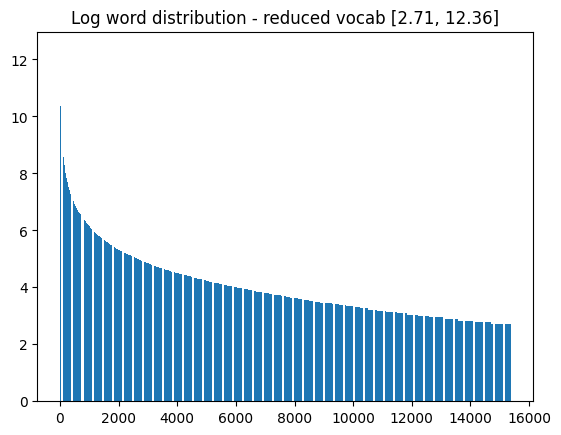

In [24]:
word_dist_reduced_vocab = sorted(list(reduced_vocab.values()), reverse=True)
plot_bar(np.log(word_dist_reduced_vocab), (f"Log word distribution - reduced vocab "
                                           f"[{np.log(min(word_dist_reduced_vocab)):.2f}, {np.log(max(word_dist_reduced_vocab)):.2f}]"))

We have some long sentences, and we may want to consider a maximum sequence length

In [25]:
def plot_histogram(data, title):
    min_ = min(data)
    max_ = max(data) + 1
    
    plt.hist(data, np.arange(min_, max_ + 1, 1))    
    plt.title(title)

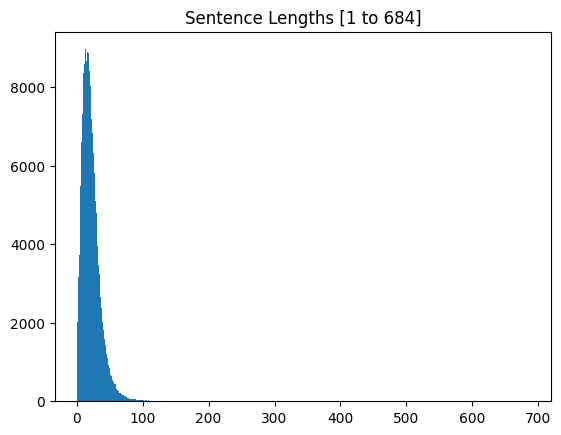

In [26]:
plot_histogram(sent_sizes, f"Sentence Lengths [{min(sent_sizes)} to {max(sent_sizes)}]")

In [27]:
sent_sizes = np.array(sent_sizes)

for size in range(10, 101, 10):
    print(f"The oversized sentences ({size}+ words) are about {100* (sent_sizes > size).sum() / num_sentences:.2f}% of all sentences")

The oversized sentences (10+ words) are about 78.54% of all sentences
The oversized sentences (20+ words) are about 43.97% of all sentences
The oversized sentences (30+ words) are about 19.91% of all sentences
The oversized sentences (40+ words) are about 8.61% of all sentences
The oversized sentences (50+ words) are about 3.87% of all sentences
The oversized sentences (60+ words) are about 1.89% of all sentences
The oversized sentences (70+ words) are about 1.03% of all sentences
The oversized sentences (80+ words) are about 0.61% of all sentences
The oversized sentences (90+ words) are about 0.38% of all sentences
The oversized sentences (100+ words) are about 0.26% of all sentences


### 1.2 Dataset & Dataloader

We will add a START, END, UNKNOWN tokens to our vocabulary to help our language model to detect a beginning of a sentence, an end of a sentence and an unknown token

In [28]:
START_TOKEN = '<START>'
END_TOKEN = '<END>'
UNKNOWN_TOKEN = '<UNKNOWN>'

token2id = {tok: i for i, tok in enumerate(reduced_vocab.keys())}
id2token = {i: tok for tok, i in token2id.items()}

UNKNOWN_ID = max(token2id.values()) + 1
START_ID = max(token2id.values()) + 2
END_ID = max(token2id.values()) + 3

token2id |= {
    UNKNOWN_TOKEN: UNKNOWN_ID,
    START_TOKEN: START_ID,
    END_TOKEN: END_ID
}
id2token |= {
    UNKNOWN_ID: UNKNOWN_TOKEN,
    START_ID: START_TOKEN,
    END_ID: END_TOKEN
}

We will define a class for the Language Model dataset, that will take different sentences from the IMDB reviews and extract data samples from each sentence.

In [ ]:
class LanguageModelDataset(Dataset):
    def __init__(self, texts, token2id, max_sequence_len):        
        self.X = []
        self.y = []

        # Convert texts to tokens, and then to samples
        for text in texts:
            for sent in sent_tokenize(text):
                tokens = [START_TOKEN, *word_tokenize(sent), END_TOKEN]

                for i, ti in enumerate(tokens[1:], start=1):
                    self.X.append([token2id.get(t, UNKNOWN_ID) for t in tokens[max(0, i - max_sequence_len):i]])
                    self.y.append(token2id.get(ti, UNKNOWN_ID))

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.y)

We will create a train-set, a validation-set and a test-set, and print some of the samples to show their structure

In [ ]:
# Dataset input texts
lm_train_text, lm_val_text = train_test_split(lm_train_text, test_size=config['val_size'], shuffle=True, random_state=42)
lm_test_text = test_pos_text + test_neg_text

# Datasets
lm_train_ds = LanguageModelDataset(lm_train_text, token2id, config['lm_max_sequence_len'])
lm_val_ds = LanguageModelDataset(lm_val_text, token2id, config['lm_max_sequence_len'])
lm_test_ds = LanguageModelDataset(lm_test_text, token2id, config['lm_max_sequence_len'])

len(lm_train_ds), len(lm_val_ds), len(lm_test_ds)

(4214166, 1407206, 6849590)

In [ ]:
for i in range(10):
    x, y = lm_train_ds[i]
    print(x, y)

[15377] 363
[15377, 363] 3411
[15377, 363, 3411] 38
[15377, 363, 3411, 38] 15376
[15377, 363, 3411, 38, 15376] 11653
[15377, 363, 3411, 38, 15376, 11653] 3417
[15377, 363, 3411, 38, 15376, 11653, 3417] 5367
[15377, 363, 3411, 38, 15376, 11653, 3417, 5367] 89
[15377, 363, 3411, 38, 15376, 11653, 3417, 5367, 89] 1630
[15377, 363, 3411, 38, 15376, 11653, 3417, 5367, 89, 1630] 76


We will create a train-loader, a validation-loader and a test-loader instances using our custom collate function to help our dataloaders deal with variable length sequences

In [29]:
def my_collate_fn(batch):
    features = pack_sequence([torch.tensor(sample[0], dtype=torch.long) for sample in batch], enforce_sorted=False)
    labels = torch.tensor([sample[1] for sample in batch], dtype=torch.long)
    return features, labels

In [ ]:
lm_train_dl = DataLoader(lm_train_ds, batch_size=config['lm_batch_size'], shuffle=True, collate_fn=my_collate_fn)
lm_val_dl = DataLoader(lm_val_ds, batch_size=config['lm_batch_size'], shuffle=True, collate_fn=my_collate_fn)
lm_test_dl = DataLoader(lm_test_ds, batch_size=config['lm_batch_size'], shuffle=False, collate_fn=my_collate_fn)

len(lm_train_dl), len(lm_val_dl), len(lm_test_dl)

(16462, 5497, 26757)

### 1.3 Model 

#### 1.3.1 Definition

We will define a Sentence Encoder class that will later help us to train a different model for a downstream classification task

In [ ]:
class SentenceEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Architecture
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers)

    def forward(self, x):

        # Select embeddings
        unpacked_x = unpack_sequence(x)
        batch_size = len(unpacked_x)
        embeddings = [self.embedding(sample) for sample in unpacked_x]
        packed_embeddings = pack_sequence(embeddings, enforce_sorted=False)

        # Forward LSTM
        output, (h_n, c_n) = self.lstm(packed_embeddings)

        return torch.transpose(c_n, 0, 1).reshape(batch_size, -1)

We will define a class for the Language Model

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super().__init__()

        # Architecture
        self.sentence_encoder = SentenceEncoder(vocab_size, embedding_dim, hidden_dim, num_layers)

        middle_dim = int(vocab_size**0.35 * (hidden_dim * num_layers)**0.65)
        self.fc1 = nn.Linear(in_features=hidden_dim * num_layers, out_features=middle_dim)
        self.relu6 = nn.ReLU6()
        self.fc2 = nn.Linear(in_features=middle_dim, out_features=vocab_size)

    def forward(self, x):

        # Feature extractor
        sentence_features = self.sentence_encoder(x)

        # Forward Fully-Connected
        pred = self.fc1(sentence_features)
        pred = self.relu6(pred)
        pred = self.fc2(pred)

        return pred

#### 1.3.2 Training

We will define a class that will help us automate the process of training & validation our model, evaluating it, saving some checkpoints, and log the training metrics throughout the training process

In [30]:
class Logger:
    def __init__(self, log_dir):
        if os.path.exists(f'runs/{log_dir}'):
            shutil.rmtree(f'runs/{log_dir}')
        %cd runs 
        self.writer = SummaryWriter(log_dir)
        %cd ..
        
        self.step_dict = {}
    
    def __call__(self, main_tag, scalar):
        self.step_dict[main_tag] = self.step_dict.get(main_tag, 1)
        self.writer.add_scalar(main_tag, scalar, self.step_dict[main_tag])
        self.step_dict[main_tag] += 1

In [31]:
class Trainer:
    def __init__(self, log_dir):
        self.logger = Logger(log_dir)
        os.makedirs(f'models/{log_dir}')

    def train_batch(self, model, X, y, loss_fn, optimizer):    
        model.train()

        # Forward & Backward
        optimizer.zero_grad()
        predictions = model(X)
        num_correct = (torch.argmax(predictions, dim=1) == y).sum().item()
        loss = loss_fn(predictions, y)
        loss.backward()
        optimizer.step()

        return loss.item(), num_correct

    def test_batch(self, model, X, y, loss_fn, optimizer):
        model.eval()

        with torch.no_grad():

            # Forward
            predictions = model(X)
            num_correct = (torch.argmax(predictions, dim=1) == y).sum().item()
            loss = loss_fn(predictions, y)
        
        return loss.item(), num_correct

    def single_epoch(self, model, dataloader, device, batch_fn, loss_fn, optimizer, tag):
        epoch_loss = 0.
        epoch_num_correct = 0
        num_batches = len(dataloader.batch_sampler)
        num_samples = len(dataloader.sampler)

        # Progress bar
        with tqdm(desc=batch_fn.__name__, total=num_batches, file=sys.stdout) as pbar:

            # Run batches
            for X, y in dataloader:
                batch_loss, batch_num_correct = batch_fn(model, X.to(device), y.to(device), loss_fn, optimizer)
                epoch_loss += batch_loss
                epoch_num_correct += batch_num_correct
                
                pbar.set_description(f'{tag} ({batch_loss:.3f})')
                pbar.update()

                self.logger(f"Loss/{tag}_batch", batch_loss)
                self.logger(f"Accuracy/{tag}_batch", batch_num_correct / dataloader.batch_size)
            
            avg_loss = epoch_loss / num_batches
            accuracy = epoch_num_correct / num_samples

            pbar.set_description(f'{tag} (Avg. Loss {avg_loss:.3f}, Accuracy {accuracy:.3f})')

            self.logger(f"Loss/{tag}_epoch", avg_loss)
            self.logger(f"Accuracy/{tag}_epoch", accuracy)

        return avg_loss

    def resume(self, model, train_dl, val_dl, device, optimizer, loss_fn, num_epochs, start_epoch, save_every=1):
        model.to(device)

        train_losses = []
        val_losses = []
        
        for e in range(start_epoch, num_epochs + start_epoch):

            print(f"--------------- epoch {e}/{num_epochs} ---------------")
            train_losses.append(self.single_epoch(model, train_dl, device, self.train_batch, loss_fn, optimizer, "Train"))

            if (e + 1) % save_every == 0:
                torch.save(model, f'models/{self.logger.writer.log_dir}/epc{e}')  

            val_losses.append(self.single_epoch(model, val_dl, device, self.test_batch, loss_fn, None, "Validation"))

        model.to('cpu')

        return train_losses, val_losses
        
    def start(self, model, train_dl, val_dl, device, optimizer, loss_fn, num_epochs, save_every=1):
        return self.resume(model, train_dl, val_dl, device, optimizer, loss_fn, num_epochs, 1, save_every)

    def evaluate(self, model, test_dl, device, loss_fn):
        model.to(device)

        test_loss = self.single_epoch(model, test_dl, device, self.test_batch, loss_fn, None, "Test")

        model.to('cpu')

        return test_loss

We will create our Language Model instance, as well as its name that will help us distinguish between different model runs.\
Then, we will create a Trainer instance to train it, and finally we will plot the results.

In [ ]:
lm = LanguageModel(vocab_size=len(token2id), 
                   embedding_dim=config['lm_embedding_dim'], 
                   hidden_dim=config['lm_hidden_dim'], 
                   num_layers=config['lm_num_layers'])
lm_name = f"LM_smp{config['lm_sample_size']}_vcb{len(reduced_vocab)}_mbd{config['lm_embedding_dim']}_hdn{config['lm_hidden_dim']}"
lm_path = f"models/{lm_name}"

print(f"Name: {lm_name}")
print(f"Path: {lm_path}")
print(f"Model: {lm}")

Name: LM_smp10000_vcb15376_mbd300_hdn600
Path: models/LM_smp10000_vcb15376_mbd300_hdn600
Model: LanguageModel(
  (sentence_encoder): SentenceEncoder(
    (embedding): Embedding(15379, 300)
    (lstm): LSTM(300, 600)
  )
  (fc1): Linear(in_features=600, out_features=1867, bias=True)
  (relu6): ReLU6()
  (fc2): Linear(in_features=1867, out_features=15379, bias=True)
)


In [ ]:
lm_trainer = Trainer(lm_name)

/content/drive/MyDrive/Colab Notebooks/NLP/runs
/content/drive/MyDrive/Colab Notebooks/NLP


In [ ]:
lm_train_losses, lm_val_losses = lm_trainer.start(model=lm, 
                                                  train_dl=lm_train_dl, 
                                                  val_dl=lm_val_dl, 
                                                  device=device, 
                                                  optimizer=torch.optim.Adam(lm.parameters()), 
                                                  loss_fn=nn.CrossEntropyLoss(), 
                                                  num_epochs=config['lm_epochs'])

--------------- epoch 1/10 ---------------
Validation (Avg. Loss 4.792, Accuracy 0.228): 100%|██████████| 5497/5497 [02:44<00:00, 33.34it/s]
--------------- epoch 2/10 ---------------
Validation (Avg. Loss 4.754, Accuracy 0.233): 100%|██████████| 5497/5497 [02:45<00:00, 33.27it/s]
--------------- epoch 3/10 ---------------
Validation (Avg. Loss 4.787, Accuracy 0.237): 100%|██████████| 5497/5497 [02:45<00:00, 33.13it/s]
--------------- epoch 4/10 ---------------
Validation (Avg. Loss 4.796, Accuracy 0.239): 100%|██████████| 5497/5497 [02:43<00:00, 33.69it/s]
--------------- epoch 5/10 ---------------
Validation (Avg. Loss 4.876, Accuracy 0.240): 100%|██████████| 5497/5497 [02:48<00:00, 32.68it/s]
--------------- epoch 6/10 ---------------
Validation (Avg. Loss 4.898, Accuracy 0.240): 100%|██████████| 5497/5497 [02:43<00:00, 33.56it/s]
--------------- epoch 7/10 ---------------
Validation (Avg. Loss 4.943, Accuracy 0.241): 100%|██████████| 5497/5497 [02:43<00:00, 33.53it/s]
-------------

In [32]:
def plot_train_results(train_losses, val_losses):
    num_epochs = len(train_losses)
    epochs = np.arange(1, num_epochs + 1)

    # Plot and label the training and validation loss values
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    
    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend(loc='best')
    plt.show()

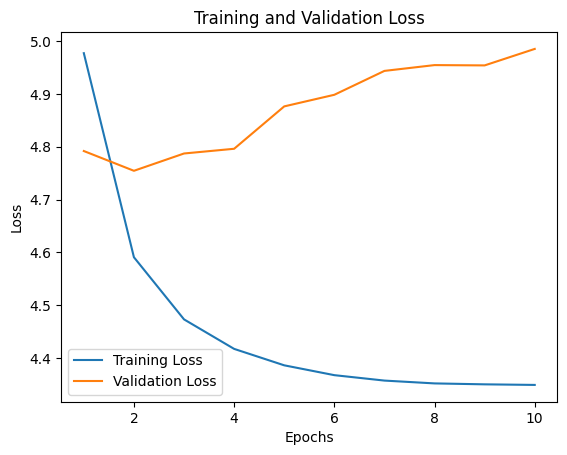

In [ ]:
plot_train_results(lm_train_losses, lm_val_losses)

### 1.4 Evaluation

#### 1.4.1 Perplexity

We will evaluate our Language Model, using the perplexity metric to determine our Language Model's ability to generalize

In [ ]:
test_loss = lm_trainer.evaluate(model=lm, 
                                test_dl=lm_test_dl,
                                device=device, 
                                loss_fn=nn.CrossEntropyLoss())

print(f'Test Loss: {test_loss:.4f}')
print(f'Perplexity: {np.exp(test_loss):.4f}')

Test (Avg. Loss 4.894, Accuracy 0.240): 100%|██████████| 26757/26757 [13:00<00:00, 34.26it/s]
Test Loss: 4.8936
Perplexity: 133.4264


## 2 Text Classification

Our second task is to define and train 2 different classification models, using the reviews we've collected from the IMDB dataset.
1. Language Model Classifier: A model that uses our pre-trained Language Model as a feature extractor.
2. GloVe Classifier: A model that uses pre-trained word embeddings (In our case we will use GloVe embeddings).




### 2.1 Dataset & Dataloader

We will define a class for text classification, that will take different reviews IMDB dataset and label them positive (1) or negative (0).

In [33]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, token2id):
        
        # Build data
        self.y = labels
        self.X = [
            [token2id.get(t, UNKNOWN_ID) for t in word_tokenize(text)]
            for text in texts
        ]

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.y)

We will create a train-set, a validation-set and a test-set, and print some of the samples to show their structure

In [34]:
clf_train_text = train_neg_text + train_pos_text
clf_train_rating = [0] * len(train_neg_text) + [1] * len(train_pos_text)
clf_train_text, clf_val_text, clf_train_rating, clf_val_rating = train_test_split(clf_train_text, 
                                                                                  clf_train_rating, 
                                                                                  test_size=config['val_size'], 
                                                                                  shuffle=True, 
                                                                                  random_state=42)
clf_test_text = test_neg_text + test_pos_text
clf_test_rating = [0] * len(test_neg_text) + [1] * len(test_pos_text)

clf_train_ds = TextClassificationDataset(clf_train_text, clf_train_rating, token2id)
clf_val_ds = TextClassificationDataset(clf_val_text, clf_val_rating, token2id)
clf_test_ds = TextClassificationDataset(clf_test_text, clf_test_rating, token2id)

In [31]:
print(len(clf_train_ds))
for i in range(10):
    x, y = clf_train_ds[i]
    print(y, x)

18750
0 [423, 18, 54, 404, 5855, 49, 14, 74, 805, 152, 515, 72, 6, 891, 443, 12282, 46, 6, 2726, 881, 38, 57, 16, 66, 18, 136, 14, 529, 12282, 2165, 6, 7755, 9, 3236, 9, 6, 13049, 203, 54, 107, 2726, 6885, 4726, 914, 16, 415, 3804, 14, 250, 1580, 76, 1277, 76, 4991, 3461, 38, 57, 801, 9, 520, 38, 118, 147, 82, 225, 11883, 46, 1553, 6550, 14, 258, 1331, 2014, 9, 6, 87, 1818, 79, 12282, 4373, 15376, 22, 1698, 158, 64, 404, 361, 118, 400, 14, 6093, 90, 136, 814, 12282, 38, 118, 90, 1473, 8897, 2554, 72, 4517, 1827, 13413, 15376, 5546, 14, 258, 8742, 72, 6, 35, 5891, 647, 56, 2641, 76, 152, 6, 2235, 4966, 1108, 8742, 26, 300, 3260, 339, 15376, 14, 5454, 62, 6, 12282, 38, 6, 728, 18, 1737, 14, 258, 2145, 18, 4963, 715, 83, 1552, 38, 33, 1041, 149, 18, 2371, 32, 54, 980, 14, 423, 18, 54, 5855, 49, 38, 2, 263, 1552, 447, 859, 38, 3635, 14, 947, 4205, 101, 3055, 8, 9, 3054, 3054, 3054, 3054, 14, 7925, 10601, 14, 13995, 83, 10065, 5710, 14]
1 [0, 34, 4126, 6431, 83, 188, 49, 38, 57, 0, 4, 443, 

We will create a train-loader, a validation-loader and a test-loader

In [35]:
clf_train_dl = DataLoader(clf_train_ds, batch_size=config['clf_batch_size'], shuffle=True, collate_fn=my_collate_fn)
clf_val_dl = DataLoader(clf_val_ds, batch_size=config['clf_batch_size'], shuffle=True, collate_fn=my_collate_fn)
clf_test_dl = DataLoader(clf_test_ds, batch_size=config['clf_batch_size'], shuffle=False, collate_fn=my_collate_fn)

### 2.2 Model Definition

We will define a Text Classifier class that will serve as a base class for both the Language Model Classifier and the End-to-End Classifier

In [36]:
class TextClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        # Classifier
        middle_dim = int(num_classes**0.2 * num_features**0.8)
        self.fc1 = nn.Linear(in_features=num_features, out_features=middle_dim)
        self.relu6 = nn.ReLU6()
        self.fc2 = nn.Linear(in_features=middle_dim, out_features=num_classes)
        
    def extract_features(self, x):
        assert False, "This method has to be overriden!"

    def forward(self, x):

        # Extract features
        feature_vec = self.extract_features(x)

        # Forward Fully-Connected
        pred = self.fc1(feature_vec)
        pred = self.relu6(pred)
        pred = self.fc2(pred)

        return pred      

**A - Language Model Classifier**

We will define a class for the Language Model Classifier

In [ ]:
class LanguageModelClassifier(TextClassifier):
    def __init__(self, sentence_encoder, num_classes):
        super().__init__(sentence_encoder.hidden_dim * sentence_encoder.num_layers, num_classes)

        self.sentence_encoder = sentence_encoder

        for param in self.sentence_encoder.parameters():
            param.requires_grad = False

    def extract_features(self, x):
        return self.sentence_encoder(x)

**B - GloVe Classifier**

We will define a class for the GloVe Classifier

In [37]:
class GloVeClassifier(TextClassifier):
    def __init__(self, id2token, embeddings, hidden_dim, num_layers, num_classes):
        super().__init__(hidden_dim * num_layers * 2, num_classes)

        self.num_layers = num_layers

        self.__build_embeddings(embeddings, id2token)
        self.lstm = nn.LSTM(input_size=len(embeddings[1]), 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers,
                            bidirectional=True)

    def __build_embeddings(self, embeddings, id2token):
        
        embedding_size = len(embeddings[0])
        num_embeddings = len(id2token) + 1

        self.embedding = torch.randn(num_embeddings, embedding_size)

        # Select pretrained vectors
        for i, w in id2token.items():
            if w in embeddings:
                self.embedding[i] = torch.tensor(embeddings[w])

        self.embedding = nn.Embedding.from_pretrained(self.embedding, freeze=True)

    def extract_features(self, x):

        # Select embeddings
        unpacked_x = unpack_sequence(x)
        batch_size = len(unpacked_x)
        embeddings = [self.embedding(sample) for sample in unpacked_x]
        packed_embeddings = pack_sequence(embeddings, enforce_sorted=False)

        # Forward LSTM
        output, (h_n, c_n) = self.lstm(packed_embeddings)

        return torch.transpose(c_n, 0, 1).reshape(batch_size, -1)

### 2.3 Training

**A - Language Model Classifier**

We will use our pre-trained Language Model, or we can load some Language Model's checkpoint.\
Then, we will create a Language Model Classifier instance, and a Trainer to train our model, and finally we will plot the training results.


In [ ]:
# lm_loaded_name = lm_name
# lm_loaded_epoch = config["lm_epochs"]
# lm_loaded = torch.load(f'models/{lm_loaded_name}/epc{lm_loaded_epoch}')

In [ ]:
lm_clf = LanguageModelClassifier(lm.sentence_encoder, num_classes=2)
lm_clf_name = f"CLF_{lm_name}"
lm_clf_path = f"models/{lm_clf_name}"

print(f"Name: {lm_clf_name}")
print(f"Path: {lm_clf_path}")
print(f"Model: {lm_clf}")

Name: CLF_LM_smp10000_vcb15376_mbd300_hdn600
Path: models/CLF_LM_smp10000_vcb15376_mbd300_hdn600
Model: LanguageModelClassifier(
  (fc1): Linear(in_features=600, out_features=191, bias=True)
  (relu6): ReLU6()
  (fc2): Linear(in_features=191, out_features=2, bias=True)
  (sentence_encoder): SentenceEncoder(
    (embedding): Embedding(15379, 300)
    (lstm): LSTM(300, 600)
  )
)


In [ ]:
lm_clf_trainer = Trainer(lm_clf_name)

/content/drive/MyDrive/Colab Notebooks/NLP/runs
/content/drive/MyDrive/Colab Notebooks/NLP


In [ ]:
lm_clf_train_losses, lm_clf_val_losses = lm_clf_trainer.start(model=lm_clf, 
                                                              train_dl=clf_train_dl, 
                                                              val_dl=clf_val_dl, 
                                                              device=device, 
                                                              optimizer=torch.optim.Adam(lm_clf.parameters()), 
                                                              loss_fn=nn.CrossEntropyLoss(), 
                                                              num_epochs=config['clf_epochs'])

--------------- epoch 1/10 ---------------
Validation (Avg. Loss 0.658, Accuracy 0.589): 100%|██████████| 25/25 [00:01<00:00, 15.03it/s]
--------------- epoch 2/10 ---------------
Validation (Avg. Loss 0.649, Accuracy 0.595): 100%|██████████| 25/25 [00:01<00:00, 14.71it/s]
--------------- epoch 3/10 ---------------
Validation (Avg. Loss 0.644, Accuracy 0.611): 100%|██████████| 25/25 [00:01<00:00, 15.38it/s]
--------------- epoch 4/10 ---------------
Validation (Avg. Loss 0.648, Accuracy 0.599): 100%|██████████| 25/25 [00:01<00:00, 15.16it/s]
--------------- epoch 5/10 ---------------
Validation (Avg. Loss 0.643, Accuracy 0.612): 100%|██████████| 25/25 [00:01<00:00, 14.93it/s]
--------------- epoch 6/10 ---------------
Validation (Avg. Loss 0.644, Accuracy 0.607): 100%|██████████| 25/25 [00:01<00:00, 14.88it/s]
--------------- epoch 7/10 ---------------
Validation (Avg. Loss 0.643, Accuracy 0.613): 100%|██████████| 25/25 [00:01<00:00, 14.95it/s]
--------------- epoch 8/10 --------------

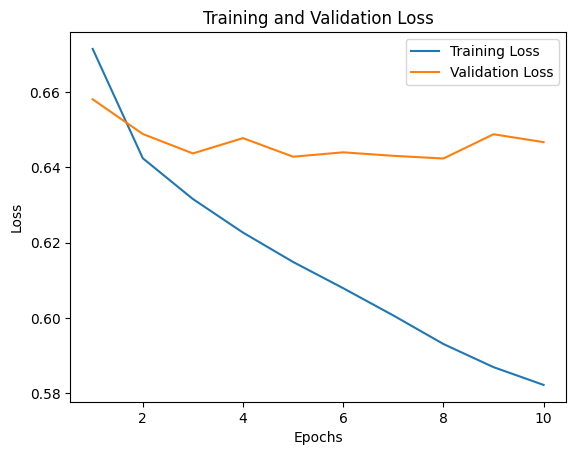

In [ ]:
plot_train_results(lm_clf_train_losses, lm_clf_val_losses)

**B - GloVe Classifier**

We will create a GloVe Classifier instance, and a Trainer to train our model, and finally we will plot the training results.

In [38]:
glv_clf = GloVeClassifier(id2token=id2token, 
                          embeddings=clf_embeddings, 
                          hidden_dim=config['clf_hidden_dim'], 
                          num_layers=config['clf_num_layers'], 
                          num_classes=2)
glv_clf_name = f"GLV_CLF_vcb{len(reduced_vocab)}_mbd{config['clf_embeddings']}_hdn{config['clf_hidden_dim']}"
glv_clf_path = f"models/{glv_clf_name}"

print(f"Name: {glv_clf_name}")
print(f"Path: {glv_clf_path}")
print(f"Model: {glv_clf}")

Name: GLV_CLF_vcb15376_mbdglove-wiki-gigaword-300_hdn600
Path: models/GLV_CLF_vcb15376_mbdglove-wiki-gigaword-300_hdn600
Model: GloVeClassifier(
  (fc1): Linear(in_features=2400, out_features=581, bias=True)
  (relu6): ReLU6()
  (fc2): Linear(in_features=581, out_features=2, bias=True)
  (embedding): Embedding(15380, 300)
  (lstm): LSTM(300, 600, num_layers=2, bidirectional=True)
)


In [41]:
glv_clf_trainer = Trainer(glv_clf_name)

/content/drive/MyDrive/Colab Notebooks/NLP/runs
/content/drive/MyDrive/Colab Notebooks/NLP


In [42]:
glv_clf_train_losses, glv_clf_val_losses = glv_clf_trainer.start(model=glv_clf, 
                                                                 train_dl=clf_train_dl, 
                                                                 val_dl=clf_val_dl, 
                                                                 device=device, 
                                                                 optimizer=torch.optim.Adam(glv_clf.parameters()), 
                                                                 loss_fn=nn.CrossEntropyLoss(), 
                                                                 num_epochs=config['clf_epochs'])

--------------- epoch 1/10 ---------------
Validation (Avg. Loss 0.526, Accuracy 0.733): 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]
--------------- epoch 2/10 ---------------
Validation (Avg. Loss 0.529, Accuracy 0.730): 100%|██████████| 25/25 [00:02<00:00,  9.73it/s]
--------------- epoch 3/10 ---------------
Validation (Avg. Loss 0.541, Accuracy 0.741): 100%|██████████| 25/25 [00:02<00:00,  9.69it/s]
--------------- epoch 4/10 ---------------
Validation (Avg. Loss 0.532, Accuracy 0.728): 100%|██████████| 25/25 [00:02<00:00,  9.71it/s]
--------------- epoch 5/10 ---------------
Validation (Avg. Loss 0.357, Accuracy 0.851): 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]
--------------- epoch 6/10 ---------------
Validation (Avg. Loss 0.323, Accuracy 0.872): 100%|██████████| 25/25 [00:02<00:00,  9.72it/s]
--------------- epoch 7/10 ---------------
Validation (Avg. Loss 0.393, Accuracy 0.837): 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]
--------------- epoch 8/10 --------------

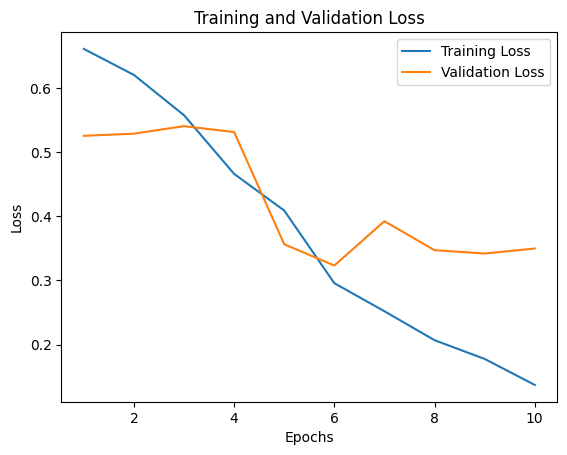

In [43]:
plot_train_results(glv_clf_train_losses, glv_clf_val_losses)

### 2.4 Evaluation

#### 2.4.1 Scores

We will define some functions that will help us apply our classifiers on our test-set and plot their respective confusion matrix

In [44]:
def predict(clf, dataloader):
    clf.eval()
    clf.to(device)

    y_pred = []
    y_true = []

    with torch.no_grad():
        for i, (X, y) in enumerate(clf_test_dl, start=1):

            # Collect predictions & labels
            y_pred += torch.argmax(clf(X.to(device)), axis=1).tolist()
            y_true += y.tolist()

    return y_pred, y_true

def plot_confusion_matrix(clf, dataloader, clf_name):
    y_pred, y_true = predict(clf, dataloader)
    accuracy = (np.array(y_pred) == np.array(y_true)).sum() / len(y_true)
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=cm)
    plt.ylabel("Ground Truth")
    plt.xlabel("Predictions")
    plt.title(f"{clf_name} ({100 * accuracy:.2f}%)")

**A - Language Model Classifier**

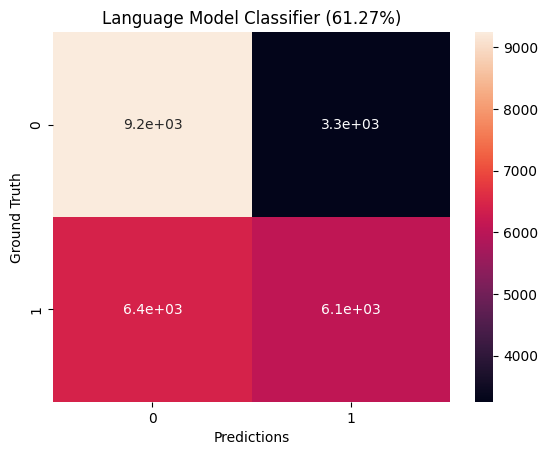

In [ ]:
plot_confusion_matrix(lm_clf, clf_test_dl, "Language Model Classifier")

**B - GloVe Classifier**

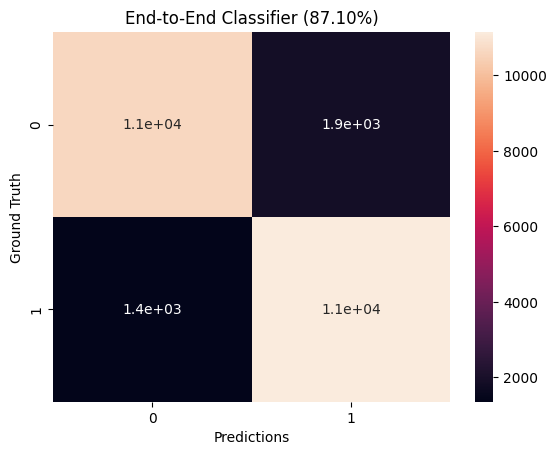

In [45]:
plot_confusion_matrix(glv_clf, clf_test_dl, "End-to-End Classifier")

#### 2.4.2 Error Analysis

We will define a function that will help us retrieve samples from the confusion matrix:

1. False Positive
2. False Negative

In [46]:
def get_error_examples(clf, dataset, num_examples=3):

    examples = [[], []]
    found = np.zeros(2)

    # Look for examples
    for x, y in dataset:

        # Compare
        if found[y] < num_examples:
            pred = torch.argmax(clf(pack_sequence([torch.tensor(x, dtype=torch.long)]))).item()
            if pred != y:
                examples[y].append(x)
                found[y] += 1
        
        # Done 
        if np.all(found == num_examples):
            break
                
    # More convenient to select from dictionary
    return {
        "False Positive": examples[0],
        "False Negative": examples[1]
    }

We will define a function that will help us convert a sample into text

In [48]:
def sample_to_text(sample, id2token):
    return ' '.join([id2token[i] for i in sample])

**A - Language Model Classifier**

In [ ]:
lm_clf_examples = get_error_examples(lm_clf, clf_test_ds)

In [ ]:
for ex_type, examples in lm_clf_examples.items():
    print(ex_type)
    print('==============')

    for ex in examples:
        print(f"({len(ex)} tokens) {sample_to_text(ex, id2token)}")
    print('\n')

False Positive
(343 tokens) Not even the Beatles could write songs everyone liked , and although Walter Hill is no <UNKNOWN> he 's second to none when it comes to thought provoking action movies . The nineties came and social <UNKNOWN> were changing in music and film , the <UNKNOWN> of the <UNKNOWN> turned movie star was in full swing , the acting took a back seat to each man 's <UNKNOWN> <UNKNOWN> accent and transparent acting . This was one of the many <UNKNOWN> movies i saw as a kid and loved , only to watch them later and cringe . Bill Paxton and William <UNKNOWN> are firemen with basic lives until a burning building tenant about to go up in flames hands over a map with gold implications . I hand it to Walter for quickly and neatly setting up the main characters and location . But i fault everyone involved for turning out <UNKNOWN> performances . <UNKNOWN> and cube must have been red hot at this time , and while I 've enjoyed both their careers as <UNKNOWN> , in my opinion they fel

**B - GloVe Classifier**

In [51]:
glv_clf_examples = get_error_examples(glv_clf, clf_test_ds)

In [52]:
for ex_type, examples in glv_clf_examples.items():
    print(ex_type)
    print('==============')

    for ex in examples:
        print(f"({len(ex)} tokens) {sample_to_text(ex, id2token)}")
    print('\n')

False Positive
(187 tokens) Once again Mr. Costner has dragged out a movie for far longer than necessary . Aside from the terrific sea rescue sequences , of which there are very few I just did not care about any of the characters . Most of us have ghosts in the closet , and Costner 's character are realized early on , and then forgotten until much later , by which time I did not care . The character we should really care about is a very cocky , <UNKNOWN> <UNKNOWN> <UNKNOWN> . The problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a <UNKNOWN> closet . His only obstacle appears to be winning over Costner . Finally when we are well past the half way point of this stinker , Costner tells us all about <UNKNOWN> 's ghosts . We are told why <UNKNOWN> is driven to be the best with no prior <UNKNOWN> or foreshadowing . No magic here , it was all I could do to keep from turning it off an hour in .
(272 tokens) <UNKNOWN> pictures ( movies is n

#### 2.4.3 Conlusions

As we can see, the reviews are sequences that contain few hundreds of tokens. The errors for both models might be due to the fact that they weren't able to learn a context that big.

In addition, there are a lot of tokens that are UNKNOWN to our vocabulary, making it harder for our classifiers to determine the right classification.

To sum up, it seems that our Language Model Classifier was able to learn, as it scored above 61% accuracy on the test set. However, our GloVe classifier was much better, as it had above 87% accuracy on the test set.